In [3]:
library(igraph)
library(dplyr)
library(Matrix)
library(ggplot2)
library(gridExtra)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Data prep

In [81]:
# load follower adjacency matrix. matrix named 'y'
load('Barbera/adj-matrix-US.rdata')

# load the retweets data. df named 'retweets'
load('Barbera/retweets-data.rdata')

# load the users data. df named 'users'
load('Barbera/users-data-US.rdata')

# load elites data. df named 'results'
load('Barbera/results-elites-US.rdata')

In [3]:
elites <- results[,c(1,2)]
colnames(elites) <- c('uid', 'ideal_point')

followers <- users[,c('uid', 'theta')]
colnames(followers) <- c('uid', 'ideal_point')

nodes <- rbind(followers, elites)

In [4]:
# subset into left and right based on theta
# calculate degree for each uid
# fit power law
# subset to candidate specific tweets
obama <- retweets[retweets$candidate == 'Obama',c(2,3)]
romney <- retweets[retweets$candidate == 'Romney',c(2,3)]

## Popularity retweet

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



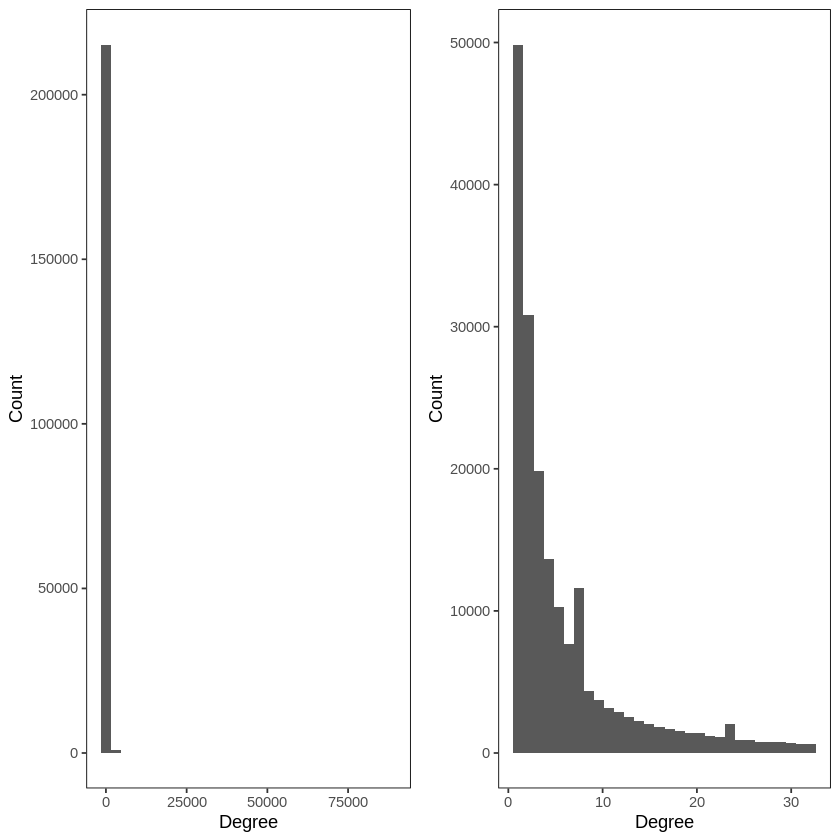

In [92]:
g_retweet <- graph_from_edgelist(as.matrix(retweets[,c(2,3)]))
# get the degree of nodes in the retweet network
d_retweet <- degree(g_retweet)

# Identify outliers
outliers <- boxplot(d_retweet, plot=FALSE)$out

# drop from the list
d_noout<- d_retweet[-which(d_retweet %in% outliers)]

# histogram without outliers
d_hist <- ggplot(as.data.frame(d_noout), aes(x=d_noout)) + 
    geom_histogram() +
    labs(x='Degree', y='Count') +
    theme(panel.border=element_rect(fill=NA), panel.background = element_blank())

# histogram with outliers
d_histout <- ggplot(as.data.frame(d_retweet), aes(x=d_retweet)) + 
    geom_histogram() +
    labs(x='Degree', y='Count') +
    theme(panel.border=element_rect(fill=NA), panel.background = element_blank())

# plot side by side
degree_grid <- grid.arrange(d_histout, 
                           d_hist, 
                           ncol = 2)

# save
ggsave('plots/degree.png', plot = degree_grid, width = 10, height = 5)

# Attachment

In [15]:
# histogram of degree
d_hist <- hist(d_retweet)

# Plot attachment
png('plots/attachment.png', width = 500, height = 500)
plot(1:length(d_hist$counts), d_hist$counts+1, xlab = "Degree", ylab = "Frequency", cex.lab = 1.5, main = "Scale-Free (log-log scale)", log = "xy", type = "b")
dev.off()

png 
  2

In [16]:
# power law fit
fit_power_law(d_retweet)

$continuous
[1] FALSE

$alpha
[1] 2.487881

$xmin
[1] 1434

$logLik
[1] -11446.73

$KS.stat
[1] 0.01664783

$KS.p
[1] 0.8515818

## Assortativity

In [4]:
# load the retweets data. df named 'retweets'
load('Barbera/retweets-data.rdata')
# load the users data. df named 'users'
load('Barbera/users-data-US.rdata')

# create the initial graph
g_retweet <- graph_from_edgelist(as.matrix(retweets[,c(2,3)]))

# get a list of all nodes in the data set
edgeids <- V(g_retweet)$name

users <- users[,c(9, 1, 8)]
# identify nodes in the retweet edge list that don't have a point estimate
missing <- edgeids[-which(edgeids %in% users$uid)]
# remove nodes with no point estimate
g <- delete_vertices(g_retweet, missing)
# create a new edge list
retweets_clean <- igraph::as_data_frame(g, what = 'edges')
# create a new graph object from clean edge list and node list
g <- graph_from_data_frame(retweets_clean, directed = TRUE, vertices = users)


# repeat this for all ideological groups

# subset to cons, lib, and mod data frames
c_users <- users[users$type == 'Conservatives', c('uid', 'theta', 'type')]
# get a list of nodes not in the list of cons users
c_missing <- edgeids[-which(edgeids %in% c_users$uid)]
# delete those users from the graph
c_retweet <- delete_vertices(g_retweet, c_missing)
# get a clean edge list
c_clean <- igraph::as_data_frame(c_retweet, what = 'edges')
# create a new graph object
cg <- graph_from_data_frame(c_clean, directed = TRUE, vertices = c_users)


l_users <- users[users$type == 'Liberals', c('uid', 'theta')]
# get a list of nodes not in the list of cons users
l_missing <- edgeids[-which(edgeids %in% l_users$uid)]
# delete those users from the graph
l_retweet <- delete_vertices(g_retweet, l_missing)
# get a clean edge list
l_clean <- igraph::as_data_frame(l_retweet, what = 'edges')
# create a new graph object
lg <- graph_from_data_frame(l_clean, directed = TRUE, vertices = l_users)

m_users <- users[users$type == 'Moderates', c('uid', 'theta')]
# get a list of nodes not in the list of cons users
m_missing <- edgeids[-which(edgeids %in% m_users$uid)]
# delete those users from the graph
m_retweet <- delete_vertices(g_retweet, m_missing)
# get a clean edge list
m_clean <- igraph::as_data_frame(m_retweet, what = 'edges')
# create a new graph object
mg <- graph_from_data_frame(m_clean, directed = TRUE, vertices = m_users)

In [141]:
# lower assortativity in partisan networks indicates
# propensity to retweet disagreements
assortativity(g, types1 = V(g)$theta)
assortativity(cg, types1 = V(cg)$theta)
assortativity(lg, types1 = V(lg)$theta)
assortativity(mg, types1 = V(mg)$theta)

[1] 0.7462079

[1] 0.1278305

[1] 0.2700945

[1] 0.7551174

## Transitivity

In [76]:
# load the retweets data. df named 'retweets'
load('Barbera/retweets-data.rdata')

# load the users data. df named 'users'
load('Barbera/users-data-US.rdata')
# subset user data to uid and theta columns
users <- users[,c(9, 1, 8)]

# create the initial graph
g_retweet <- graph_from_edgelist(as.matrix(retweets[,c(2,3)]))

# get a list of all vertex names in the original edge list
edgeids <- V(g_retweet)$name
# identify nodes in the retweet edge list that don't have a point estimate
missing <- edgeids[-which(edgeids %in% users$uid)]
# remove nodes with no point estimate
g_retweet <- delete_vertices(g_retweet, missing)
# create a new edge list
retweets_clean <- igraph::as_data_frame(g_retweet, what = 'edges')

# create a new graph object from clean edge list and node list
g <- graph_from_data_frame(retweets_clean, directed = TRUE, vertices = users)

# assign transitivity
V(g)$trans <- transitivity(g, 'local')

# transitivity of conservatives
mean(V(g)[V(g)$type == 'Conservatives']$trans, na.rm = TRUE)

mean(V(g)[V(g)$type == 'Liberals']$trans, na.rm = TRUE)

mean(V(g)[V(g)$type == 'Moderates']$trans, na.rm = TRUE)

mean(V(g)$trans, na.rm = TRUE)
transitivity(g)

[1] 0.1529686

[1] 0.1462013

[1] 0.1170393

[1] 0.1278535

In [78]:
median(V(g)[V(g)$type == 'Conservatives']$trans, na.rm = TRUE)

median(V(g)[V(g)$type == 'Liberals']$trans, na.rm = TRUE)

median(V(g)[V(g)$type == 'Moderates']$trans, na.rm = TRUE)

[1] 0.1215846

[1] 0.1071429

[1] 0.06666667

# Centrality

In [89]:
# calculate degree centrality with cutoff of 3. Takes a bit...
cent <- estimate_betweenness(g, directed = TRUE, cutoff = 3)
save(cent, file = 'centrality.rdata')
# assign as attribute
V(g)$cent <- cent

In [71]:
# load if already calculated
load('centrality.rdata')
V(g)$cent <- cent

# outliers dominate to the point that mean and median are useless
# accordingly take the log and then the mean
mean(log(V(g)[V(g)$type == 'Conservatives']$cent + 1))
mean(log(V(g)[V(g)$type == 'Liberals']$cent + 1))
mean(log(V(g)[V(g)$type == 'Moderates']$cent + 1))
mean(log((V(g)$cent + 1)))

# Recpiprocity

In [90]:
# create a graph from the edge list
g <- graph_from_edgelist(as.matrix(retweets[,c(2,3)]))
# get a list of all vertex names in the original edge list
edgeids <- V(g)$name

# get a list of all vertex names in the elites and followers data
# elites data
elites <- results[,c(1,2)]
colnames(elites) <- c('uid', 'ideal_point')
# followers data
followers <- users[,c('uid', 'theta')]
colnames(followers) <- c('uid', 'ideal_point')
# combine elites and followers data
nodes <- rbind(followers, elites)

# remove vertices with no point estimates from the data
# identify nodes in the retweet edge list that don't have a point estimate
missing <- edgeids[-which(edgeids %in% nodes$uid)]
# remove nodes from the network with no point estimate
g <- delete_vertices(g, missing)
# create a new edge list after dropping vertices
retweets_clean <- igraph::as_data_frame(g, what = 'edges')

# add meta data to the node list
# count number of times a node retweeted someone else
retweet_count <- count(retweets_clean, from)
colnames(retweet_count) <- c('uid', 'retweets')
# count the number of times a node was retweeted
retweeted_count <- count(retweets_clean, to)
colnames(retweeted_count) <- c('uid', 'retweeted')
# left join retweets with node list
nodes <- left_join(nodes, retweet_count, by = 'uid')
# left join retweeted with node list
nodes <- left_join(nodes, retweeted_count, by = 'uid')
# fill NA with zero 
nodes$retweets[is.na(nodes$retweets)] <- 0
nodes$retweeted[is.na(nodes$retweeted)] <- 0

# add reciprocity
# create retweet adjacency matrix
retweet_adj <- as_adj(g, edges=TRUE, sparse = TRUE)
# convert from numeric to binary sparse matrix
retweet_adj <- as(retweet_adj, "ngCMatrix")
# multiply the matrix aby its inverse and sum the rows to get the number of reciprocated ties
recip <- as.matrix(rowSums(retweet_adj*t(retweet_adj)))
# convert to df for joining
recip <- as.data.frame(recip)
recip$uid <- rownames(recip)
colnames(recip) <- c('reciprocity', 'uid')
# join to node list
nodes <- left_join(nodes, recip, by = 'uid')
# replace NA with 0
nodes$reciprocity[is.na(nodes$reciprocity)] <- 0

# create a new graph object from clean edge list and node list
g <- graph_from_data_frame(retweets_clean, directed = TRUE, vertices = nodes)

In [91]:
# plot reciprocity and save
recip_scatter <- ggplot(nodes, aes(x=ideal_point, y=reciprocity)) +
    geom_point(shape=1) +
    labs(x='Ideal Point', y='Reciprocity') +
    theme(panel.border=element_rect(fill=NA), panel.background = element_blank())

ggsave('plots/reciprocity.png', plot = recip_scatter, width = 5, height = 5)

In [198]:
# avg number of mutual ties for conservatives
mean(nodes[nodes$ideal_point >= 0.5, 'reciprocity'])

# avg number of mutual ties for Liberals
mean(nodes[nodes$ideal_point <= -0.5, 'reciprocity'])

# average number for moderates
mean(nodes[nodes$ideal_point >= -0.5 & nodes$ideal_point <= 0.5, 'reciprocity'])

[1] 0.9576613

[1] 0.587626

[1] 0.1694838

# Retweet network plot

In [14]:
retweetfr <- layout_with_fr(g_retweet, grid = 'nogrid')
save(retweetfr, file = "retweet_fr_layout.RData")

In [6]:
load('retweet_fr_layout.RData')

In [ ]:
plot.igraph(g_retweet, 
     layout = retweetfr,
     vertex.label = NA,
     vertex.size = 1.5,
     vertex.frame.color = NA,
     edge.color ='gray',
     edge.width = .25
    )

In [22]:
library(igraph)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [96]:
load('Barbera/users-data-US.rdata')
load('Barbera/retweets-data.rdata')


users <- users[,c(9, 1)]
rtdf <- retweets[retweets$retweeter_uid %in% users$uid, ]
rtdf <- rtdf[(rtdf$retweeted_uid %in% users$uid), ]

grt <- graph_from_data_frame(rtdf[,c(2,3)], vertices = users, directed = FALSE)

grt <- simplify(grt)

#V(grt)$ degree <- degree(grt)

#df <- as_data_frame(grt, what = 'vertices')
#head(df)

In [107]:
V(grt)$color <- ifelse(V(grt)$theta <=0, 'dark blue', 'dark red')

In [100]:
V(grt)$color

[1] "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#FDB863" "#FDB863"
    [8] "#F7F7F7" "#F7F7F7" "#B2ABD2" "#FDB863" "#F7F7F7" "#E66101" "#B2ABD2"
   [15] "#F7F7F7" "#FDB863" "#F7F7F7" "#F7F7F7" "#FDB863" "#F7F7F7" "#FDB863"
   [22] "#F7F7F7" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#FDB863" "#B2ABD2"
   [29] "#F7F7F7" "#F7F7F7" "#FDB863" "#F7F7F7" "#FDB863" "#FDB863" "#B2ABD2"
   [36] "#E66101" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#FDB863" "#5E3C99"
   [43] "#B2ABD2" "#FDB863" "#F7F7F7" "#F7F7F7" "#FDB863" "#FDB863" "#FDB863"
   [50] "#F7F7F7" "#F7F7F7" "#5E3C99" "#F7F7F7" "#F7F7F7" "#B2ABD2" "#F7F7F7"
   [57] "#F7F7F7" "#F7F7F7" "#F7F7F7" "#B2ABD2" "#F7F7F7" "#F7F7F7" "#F7F7F7"
   [64] "#F7F7F7" "#F7F7F7" "#FDB863" "#B2ABD2" "#F7F7F7" "#FDB863" "#F7F7F7"
   [71] "#B2ABD2" "#F7F7F7" "#B2ABD2" "#F7F7F7" "#FDB863" "#F7F7F7" "#F7F7F7"
   [78] "#F7F7F7" "#FDB863" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7"
   [85] "#F7F7F7" "#F7F7F7" "#F7F7F7" "#FDB863" "#FDB863" "#F7F7F7" "#B2ABD2"
   [92] "#F7F7F7" "#B2ABD2" "#F7F7F7" "#FDB863" "#FDB863" "#B2ABD2" "#5E3C99"
   [99] "#F7F7F7" "#B2ABD2" "#FDB863" "#E66101" "#F7F7F7" "#FDB863" "#F7F7F7"
  [106] "#B2ABD2" "#F7F7F7" "#FDB863" "#B2ABD2" "#F7F7F7" "#F7F7F7" "#F7F7F7"
  [113] "#B2ABD2" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7"
  [120] "#F7F7F7" "#B2ABD2" "#FDB863" "#F7F7F7" "#FDB863" "#FDB863" "#B2ABD2"
  [127] "#B2ABD2" "#F7F7F7" "#B2ABD2" "#B2ABD2" "#B2ABD2" "#FDB863" "#B2ABD2"
  [134] "#E66101" "#FDB863" "#F7F7F7" "#FDB863" "#F7F7F7" "#E66101" "#F7F7F7"
  [141] "#F7F7F7" "#FDB863" "#B2ABD2" "#F7F7F7" "#F7F7F7" "#B2ABD2" "#F7F7F7"
  [148] "#F7F7F7" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7"
  [155] "#F7F7F7" "#F7F7F7" "#FDB863" "#F7F7F7" "#FDB863" "#F7F7F7" "#E66101"
  [162] "#FDB863" "#F7F7F7" "#F7F7F7" "#FDB863" "#F7F7F7" "#FDB863" "#FDB863"
  [169] "#B2ABD2" "#F7F7F7" "#B2ABD2" "#F7F7F7" "#F7F7F7" "#FDB863" "#F7F7F7"
  [176] "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#B2ABD2"
  [183] "#B2ABD2" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#FDB863" "#FDB863"
  [190] "#F7F7F7" "#F7F7F7" "#FDB863" "#F7F7F7" "#E66101" "#F7F7F7" "#B2ABD2"
  [197] "#FDB863" "#F7F7F7" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7"
  [204] "#FDB863" "#F7F7F7" "#F7F7F7" "#FDB863" "#F7F7F7" "#F7F7F7" "#FDB863"
  [211] "#B2ABD2" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7"
  [218] "#F7F7F7" "#F7F7F7" "#F7F7F7" "#FDB863" "#FDB863" "#F7F7F7" "#B2ABD2"
  [225] "#F7F7F7" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#FDB863" "#B2ABD2"
  [232] "#B2ABD2" "#F7F7F7" "#E66101" "#FDB863" "#F7F7F7" "#B2ABD2" "#B2ABD2"
  [239] "#FDB863" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#B2ABD2" "#FDB863"
  [246] "#FDB863" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#B2ABD2"
  [253] "#F7F7F7" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7"
  [260] "#F7F7F7" "#F7F7F7" "#FDB863" "#F7F7F7" "#B2ABD2" "#5E3C99" "#F7F7F7"
  [267] "#F7F7F7" "#F7F7F7" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7"
  [274] "#F7F7F7" "#F7F7F7" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7"
  [281] "#E66101" "#FDB863" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#B2ABD2"
  [288] "#B2ABD2" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#FDB863"
  [295] "#F7F7F7" "#F7F7F7" "#FDB863" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#E66101"
  [302] "#F7F7F7" "#FDB863" "#F7F7F7" "#B2ABD2" "#E66101" "#FDB863" "#FDB863"
  [309] "#F7F7F7" "#E66101" "#FDB863" "#F7F7F7" "#F7F7F7" "#B2ABD2" "#F7F7F7"
  [316] "#F7F7F7" "#F7F7F7" "#B2ABD2" "#B2ABD2" "#FDB863" "#FDB863" "#F7F7F7"
  [323] "#FDB863" "#F7F7F7" "#5E3C99" "#F7F7F7" "#F7F7F7" "#F7F7F7" "#F7F7F7"
  [330] "#F7F7F7" "#B2ABD2" "#FDB863" "#F7F7F7" "#FDB863" "#FDB863" "#FDB863"
  [337] "#FDB863" "#F7F7F7" "#F7F7F7" "#5E3C99" "#F7F7F7" "#F7F7F7" "#FDB863"
  [344] "#F7F7F7" "#FDB863" "#FDB863" "#F7F7F7" "#FDB863" "#F7F7F7" "#B2ABD2"
  [351] "#F7F7F7" "#F7F7F7" "#FDB863" "#B2ABD2" "#E66101" "#F7F7F7" "#F7F7F7"
  [358] "#F7F7F7" "#F7F7F7

In [57]:
sing <- which(degree(grt)<=100)
grt2 = delete.vertices(grt, sing)

In [ ]:
retweetfr <- layout_with_fr(g_retweet, grid = 'nogrid')
save(retweetfr, file = "retweet_fr_layout2.RData")

In [102]:
load('Barbera/retweets-data.rdata')
g_retweet <- graph_from_edgelist(as.matrix(retweets[,c(2,3)]), directed = FALSE)
g_retweet <- simplify(g_retweet)

load('retweet_fr_layout.RData')

plot.igraph(g_retweet, 
     layout = retweetfr,
     vertex.label = NA,
     vertex.size = 1.5,
     vertex.frame.color = NA,
     edge.color ='gray',
     edge.width = .25
    )

ERROR: Error in i.parse.plot.params(graph, list(...)): object 'color' not found


In [109]:
png("plots/retweet network.png", 600, 600)

plot.igraph(grt, 
     layout = retweetfr,
     vertex.label = NA,
     vertex.size = 1.5,
     vertex.frame.color = NA,
     edge.color ='gray',
     edge.width = .25,
     color = V(grt)$color
    )

dev.off()

png 
  2

## Degree

In [61]:
# load data
load('Barbera/users-data-US.rdata')

# visualize
rtvis <- ggplot(users, aes(x=theta, y=alpha) ) +
  geom_bin2d(bins = 300) +
  ylab(expression('Popularity'[i])) + # puts a line through the graph when I label this alpha for some reason...
  xlab(expression(theta[i])) +
  scale_fill_continuous(type = "viridis", name = 'Count') +
  theme(panel.border=element_rect(fill=NA), panel.background = element_blank())

# save
ggsave(filename="plots/retweet_net.png", plot=rtvis, 
        height=5, width=5)

In [60]:
# correlation between degree and theta
V(g)$degree <- degree(g)
users <- igraph::as_data_frame(g, what = 'vertices')
cor(abs(users[users$theta >= 0.5, 'theta']), users[users$theta >= 0.5, 'degree'])
cor(abs(users[users$theta <= -0.5, 'theta']), users[users$theta <= -0.5, 'degree'])
cor(abs(users[users$theta >= -0.5 & users$theta <= 0.5, 'theta']), users[users$theta >= -0.5 & users$theta <= 0.5, 'degree'])

[1] 0.017164

[1] 0.02037282

[1] 0.0007133533

In [62]:
# Correlation between alpha and theta
load('Barbera/users-data-US.rdata')
cor(abs(users[users$theta >= 0.5, 'theta']), users[users$theta >= 0.5, 'alpha'])
cor(abs(users[users$theta <= -0.5, 'theta']), users[users$theta <= -0.5, 'alpha'])
cor(abs(users[users$theta >= -0.5 & users$theta <= 0.5, 'theta']), users[users$theta >= -0.5 & users$theta <= 0.5, 'alpha'])

cor(abs(users$theta), users$alpha)

[1] 0.1074937

[1] 0.2121824

[1] -0.08575468